# Analysis part - Charizard_Reverse_Foil_2016_Evolutions

In [1]:
library(ggplot2)
library(quantreg)


df = read.csv('lagged_merged_datasets_final/merged_Charizard_Reverse_Foil_2016_Evolutions.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock and adjclosebond (including their lags) to returns
stock_bond_cols <- grep("adjclose(stock|bond)(lag[0-9]+)?", names(df), value = TRUE)

for(col in stock_bond_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))
}


#convert volume and its lags to 'returns'
volume_cols <- grep("volume(lag[0-9]+)?", names(df), value = TRUE)

for(col in volume_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))  # Adding 1 to avoid log(0) issues
}

#remove rows with NA in the newly created return columns
df <- na.omit(df)

print(head(df))


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'quantreg' was built under R version 3.6.3"Loading required package: SparseM
Warning message:
"package 'SparseM' was built under R version 3.6.3"
Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve



        date grade8price grade9price grade10price adjclosestock      volume
2 2017-01-01       10.50    16.07000     264.2200       2278.87 70576420000
3 2017-02-01       10.50    28.75000     304.1667       2363.64 69260940000
4 2017-03-01       10.50    16.12500     210.0000       2362.72 81664010000
5 2017-04-01       10.50    13.51000     155.5900       2384.20 65369860000
6 2017-05-01        9.99    16.82333     113.6560       2411.80 79719460000
7 2017-06-01       13.99    21.49167     107.2500       2423.41 81078810000
  adjclosebond  stockreturns bondadjusted excessreturns adjclosestocklag1
2        3.051  0.0178843582      0.03051    0.02180204           2238.83
3        2.968  0.0371981601      0.02968    0.06440241           2278.87
4        3.018 -0.0003891971      0.03018   -0.01723554           2363.64
5        2.952  0.0090912087      0.02952    0.03095999           2362.72
6        2.857  0.0115762512      0.02857    0.04375775           2384.20
7        2.840  0.004813

                         grade8price_return grade9price_return
grade8price_return              1.000000000       -0.029173391
grade9price_return             -0.029173391        1.000000000
grade10price_return             0.098868651        0.242561798
adjclosestock_return           -0.217189058       -0.192101043
adjclosebond_return            -0.073044910        0.048445788
adjclosestocklag1_return        0.104531265        0.056300169
adjclosebondlag1_return         0.152718886       -0.056129855
adjclosestocklag2_return        0.030554641        0.022728515
adjclosebondlag2_return        -0.305113545       -0.008151793
adjclosestocklag3_return        0.093081596        0.039731306
adjclosebondlag3_return         0.116710151       -0.185037264
adjclosestocklag4_return       -0.056528832       -0.028047448
adjclosebondlag4_return        -0.169058741       -0.076621238
adjclosestocklag5_return        0.055221049       -0.096857374
adjclosebondlag5_return        -0.075424039       -0.01

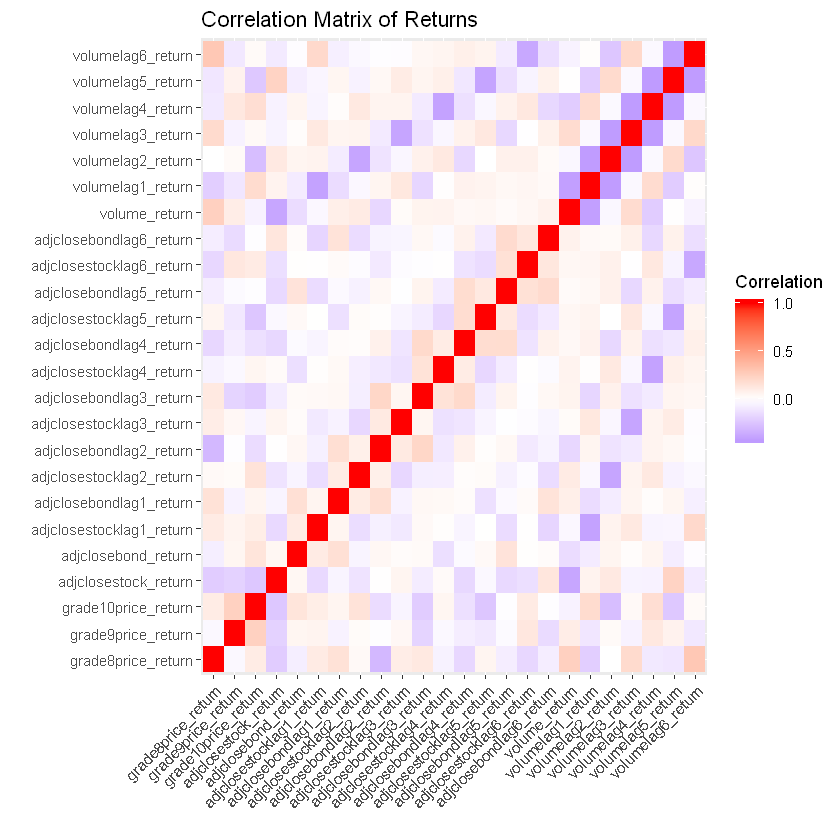

In [3]:
createReturnsCorrelationMatrix <- function(df) {
  # Load necessary libraries
  library(ggplot2)
  library(reshape2)
  
  # Use a simplified pattern to include both "_return" columns and any "volume" columns
  pattern <- "_return"
  selected_columns <- grep(pattern, names(df), value = TRUE)
  
  # Calculate the correlation matrix for the selected columns
  correlation_matrix <- cor(df[, selected_columns], use = "complete.obs")
  
  # Print the correlation matrix to the console
  print(correlation_matrix)
  
  # Melt the correlation matrix for visualization
  melted_correlation_matrix <- melt(correlation_matrix)
  
  # Create the ggplot object for the correlation matrix
  plot <- ggplot(data = melted_correlation_matrix, aes(x=Var1, y=Var2, fill=value)) +
    geom_tile() +
    scale_fill_gradient2(midpoint=0, low="blue", high="red", mid="white") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x='', y='', title='Correlation Matrix of Returns', fill='Correlation')
  
  # Explicitly print the ggplot object to ensure it's displayed
  print(plot)
  
  # Return the correlation matrix as well
  return(correlation_matrix)
}

# Assuming your adjusted dataset is in 'df'
# Example usage:
correlation_matrix <- createReturnsCorrelationMatrix(df)


## VAR model - try later - if enough time...

## Visualisation

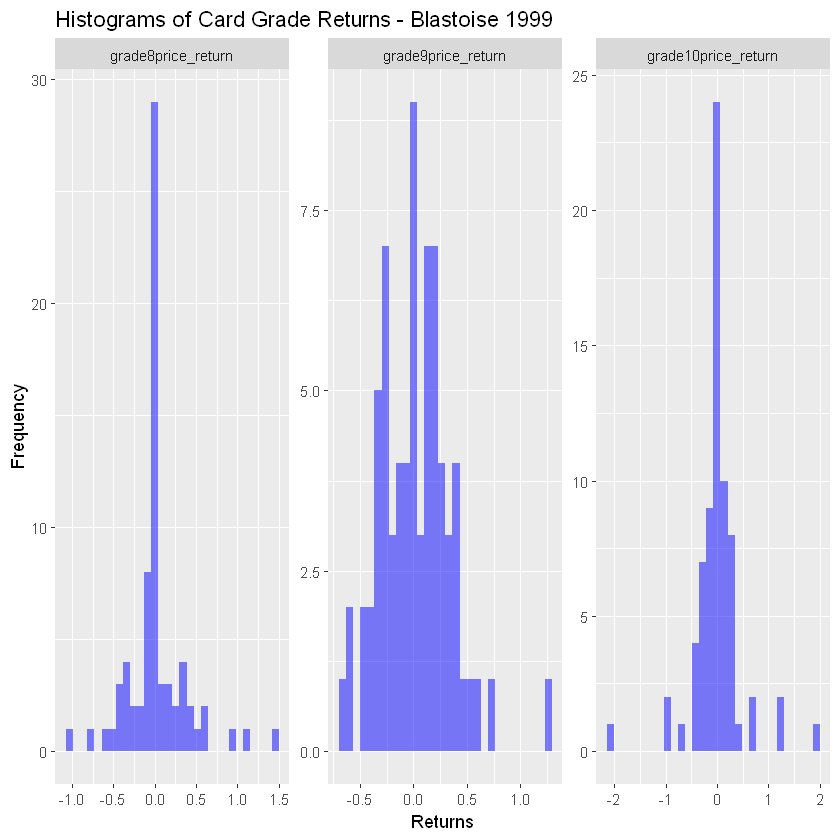

In [4]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

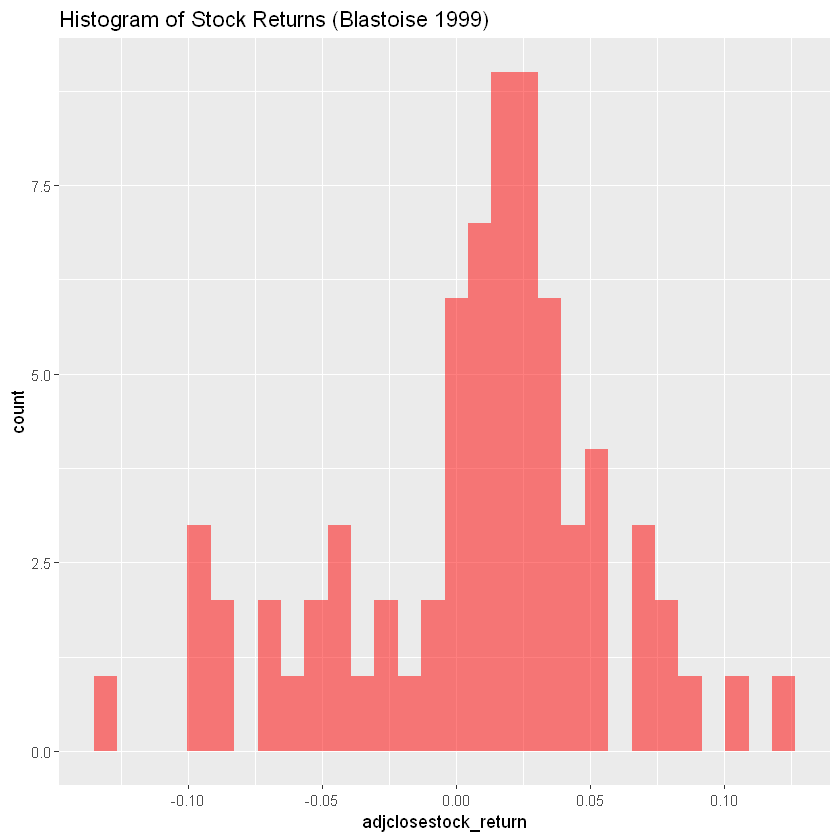

In [5]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

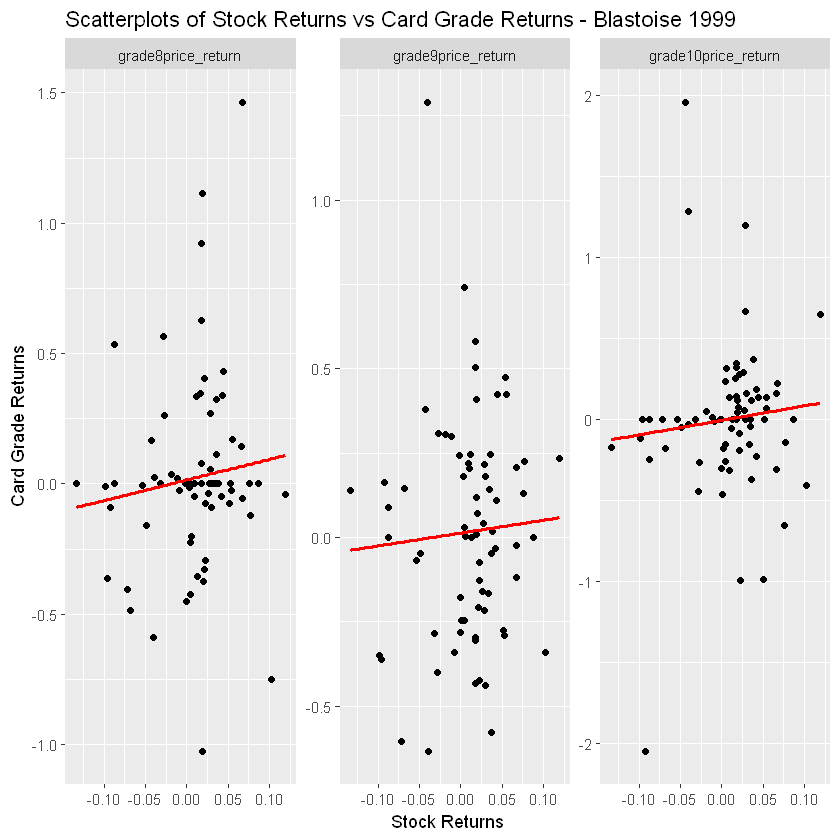

In [6]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestocklag1_return"), measure.vars = grade_returns) #ADJUST FOR DIFFERENT LAGS

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestocklag1_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Choose the variables using AIC

In [10]:

# Load necessary library
library(stats)

# Preparing the initial full model with the dependent variable (choosing one of the grade prices as an example)
# and all potential independent variables (using returns and lagged returns)
# Note: Adjust 'grade5price' to the specific grade price return you are analyzing
full_model <- lm(grade10price_return ~ adjclosestock_return + adjclosebond_return +
                 adjclosestocklag1_return + adjclosebondlag1_return +
                 adjclosestocklag2_return + adjclosebondlag2_return +
                 adjclosestocklag3_return + adjclosebondlag3_return +
                 adjclosestocklag4_return + adjclosebondlag4_return +
                 adjclosestocklag5_return + adjclosebondlag5_return +
                 adjclosestocklag6_return + adjclosebondlag6_return +
                 volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
                 volumelag4_return + volumelag5_return + volumelag6_return, data = df)

# Perform backward elimination based on AIC
reduced_model <- step(full_model, direction = "backward")

# Display the summary of the reduced model to see the selected variables and their coefficients
summary(reduced_model)


Start:  AIC=-100.97
grade10price_return ~ adjclosestock_return + adjclosebond_return + 
    adjclosestocklag1_return + adjclosebondlag1_return + adjclosestocklag2_return + 
    adjclosebondlag2_return + adjclosestocklag3_return + adjclosebondlag3_return + 
    adjclosestocklag4_return + adjclosebondlag4_return + adjclosestocklag5_return + 
    adjclosebondlag5_return + adjclosestocklag6_return + adjclosebondlag6_return + 
    volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
    volumelag4_return + volumelag5_return + volumelag6_return

                           Df Sum of Sq     RSS      AIC
- adjclosestocklag2_return  1   0.00422  9.6175 -102.942
- adjclosebondlag5_return   1   0.00509  9.6184 -102.935
- adjclosebondlag1_return   1   0.00546  9.6188 -102.932
- volumelag1_return         1   0.00687  9.6202 -102.922
- adjclosestocklag3_return  1   0.00718  9.6205 -102.919
- adjclosebondlag6_return   1   0.02393  9.6373 -102.794
- adjclosestocklag1_return  1  


Call:
lm(formula = grade10price_return ~ adjclosestock_return + adjclosebond_return + 
    adjclosebondlag3_return + adjclosestocklag5_return + volumelag2_return + 
    volumelag5_return + volumelag6_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.63344 -0.16900 -0.00808  0.24154  0.87228 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.06412    0.05056   1.268 0.209342    
adjclosestock_return     -1.80694    1.02506  -1.763 0.082714 .  
adjclosebond_return       0.81562    0.55650   1.466 0.147646    
adjclosebondlag3_return  -1.23910    0.55538  -2.231 0.029187 *  
adjclosestocklag5_return -4.21848    1.16888  -3.609 0.000604 ***
volumelag2_return        -0.64829    0.31002  -2.091 0.040495 *  
volumelag5_return        -1.03698    0.37194  -2.788 0.006974 ** 
volumelag6_return        -0.46097    0.33855  -1.362 0.178102    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


## Models

### OLS

In [12]:
#OLS
ols_model <- lm(grade10price_return ~ adjclosestock_return + adjclosebond_return + 
    adjclosebondlag3_return + adjclosestocklag5_return + volumelag2_return + 
    volumelag5_return + volumelag6_return, data = df) 

print(summary(ols_model))

library(car)

# Calculate VIF
vif_result <- vif(ols_model)
print(vif_result)

library(lmtest)

# Perform the Breusch-Pagan test
bp_test <- bptest(ols_model)

# Print the test results
print(bp_test)



Call:
lm(formula = grade10price_return ~ adjclosestock_return + adjclosebond_return + 
    adjclosebondlag3_return + adjclosestocklag5_return + volumelag2_return + 
    volumelag5_return + volumelag6_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.63344 -0.16900 -0.00808  0.24154  0.87228 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.06412    0.05056   1.268 0.209342    
adjclosestock_return     -1.80694    1.02506  -1.763 0.082714 .  
adjclosebond_return       0.81562    0.55650   1.466 0.147646    
adjclosebondlag3_return  -1.23910    0.55538  -2.231 0.029187 *  
adjclosestocklag5_return -4.21848    1.16888  -3.609 0.000604 ***
volumelag2_return        -0.64829    0.31002  -2.091 0.040495 *  
volumelag5_return        -1.03698    0.37194  -2.788 0.006974 ** 
volumelag6_return        -0.46097    0.33855  -1.362 0.178102    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


No heteroskedasticity nor multicollinearity

### Quantile regression

In [13]:
#Quantile regression
library(quantreg)

quantile_model <- rq(grade10price_return ~  adjclosestock_return + adjclosebond_return + 
    adjclosebondlag3_return + adjclosestocklag5_return + volumelag2_return + 
    volumelag5_return + volumelag6_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
                                                                                                                                   

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step




#### Results for different quantiles of the grade 10 prices x OLS estimates (red line) 

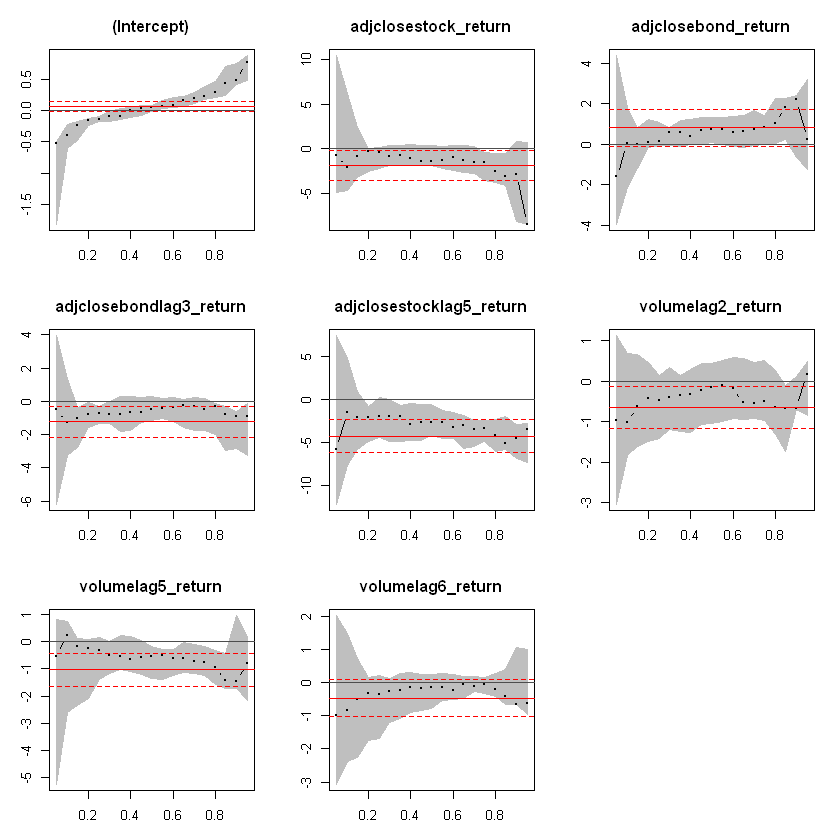

In [14]:

plot(summary(quantile_model))
